<a href="https://colab.research.google.com/github/Tongwu18/fu-yao/blob/main/Halle_1_RL3%E5%B1%82%E8%B4%A7%E6%9E%B6%E9%99%90%E5%88%B6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from typing import List, Tuple, Optional, Dict, Any
from dataclasses import dataclass, field
import copy

df = pd.read_excel("https://github.com/Tongwu18/fu-yao/raw/main/111.xlsx")
df

,玻璃索引,最短宽,高2,Count of 玻璃索引
0,1,112.0,35.0,28
1,2,112.0,35.0,13
2,3,180.0,102.0,30
3,4,180.0,102.0,15
4,5,180.0,102.0,8
...,...,...,...,...
696,697,115.0,79.5,1
697,698,114.0,63.0,1
698,699,209.0,64.0,1
699,700,143.0,64.0,15


# 环境


In [14]:
"""
玻璃货架装箱 V9
可配置参数 + 超参数分析
"""

import numpy as np
import pandas as pd
import time
from collections import Counter
import matplotlib.pyplot as plt


# 默认常量 (mm)
SHELF_W = 360.0
SHELF_H = 800.0
SEP = 27.0
GAP = 9.0
MAX_STACK1 = 4
MAX_STACK2 = 2


class Packer:
    def __init__(self, df, min_layers=3, min_layer_h=35.0):
        """
        参数:
            df: 数据
            min_layers: 最少层数 (默认3)
            min_layer_h: 每层最低高度mm (默认35)
        """
        self.min_layers = min_layers
        self.min_layer_h = min_layer_h
        self.df = df

        id_col = next((c for c in ['玻璃索引', 'glass_id', 'id'] if c in df.columns), None)
        w_col = next((c for c in ['最短宽', 'width'] if c in df.columns), None)
        h_col = next((c for c in ['高2', 'height'] if c in df.columns), None)
        cnt_col = next((c for c in ['Count of 玻璃索引', 'count'] if c in df.columns), None)

        self.ids = df[id_col].values.astype(int) if id_col else np.arange(len(df))
        self.W = df[w_col].values.astype(float)
        self.H = df[h_col].values.astype(float)
        self.C = df[cnt_col].values.astype(int)
        self.n = len(self.W)
        self.total_boxes = self.C.sum()

        total_area_m2 = np.sum(self.W * self.H * self.C) / 1e6
        self.theoretical_min = int(np.ceil(total_area_m2 / (SHELF_W * SHELF_H / 1e6)))

        self.best_order = None

    def _calc_shelf_height(self, shelf):
        n_layers = len(shelf)
        layer_heights = sum(l[0] for l in shelf)
        sep_heights = max(0, n_layers - 1) * SEP
        return layer_heights + sep_heights

    def _get_min_remaining_height(self, shelf):
        n_layers = len(shelf)
        if n_layers >= self.min_layers:
            return 0
        need_layers = self.min_layers - n_layers
        return need_layers * self.min_layer_h + need_layers * SEP

    def _can_fit_with_min_layers(self, shelf, delta=0):
        current_h = self._calc_shelf_height(shelf) + delta
        min_remaining = self._get_min_remaining_height(shelf)
        return current_h + min_remaining <= SHELF_H

    def pack(self, order):
        remaining = self.C.copy()
        shelves = [[[0.0, []]]]

        for idx in order:
            gw, gh = self.W[idx], self.H[idx]

            while remaining[idx] > 0:
                placed = False

                for shelf in shelves:
                    # 1. 尝试叠放
                    for li, layer in enumerate(shelf):
                        lh, positions = layer[0], layer[1]
                        for pi, (gidx, stk) in enumerate(positions):
                            if gidx == idx:
                                max_stk = MAX_STACK1 if li == 0 else MAX_STACK2
                                if stk < max_stk:
                                    new_h = gh * (stk + 1)
                                    test_lh = max(lh, new_h)
                                    delta = test_lh - lh

                                    old_val = shelf[li][0]
                                    shelf[li][0] = test_lh
                                    can_fit = self._can_fit_with_min_layers(shelf)
                                    shelf[li][0] = old_val

                                    if can_fit:
                                        positions[pi] = (gidx, stk + 1)
                                        shelf[li][0] = test_lh
                                        remaining[idx] -= 1
                                        placed = True
                                        break
                        if placed:
                            break
                    if placed:
                        break

                    # 2. 现有层新位置
                    for li, layer in enumerate(shelf):
                        lh, positions = layer[0], layer[1]
                        used_w = sum(self.W[g] for g, _ in positions)
                        if len(positions) > 0:
                            used_w += GAP * len(positions)

                        if used_w + gw <= SHELF_W:
                            test_lh = max(lh, gh)

                            old_val = shelf[li][0]
                            shelf[li][0] = test_lh
                            can_fit = self._can_fit_with_min_layers(shelf)
                            shelf[li][0] = old_val

                            if can_fit:
                                positions.append((idx, 1))
                                shelf[li][0] = test_lh
                                remaining[idx] -= 1
                                placed = True
                                break
                    if placed:
                        break

                    # 3. 新层
                    current_h = self._calc_shelf_height(shelf)
                    new_h_with_layer = current_h + SEP + gh
                    n_layers_after = len(shelf) + 1

                    if n_layers_after < self.min_layers:
                        need_more = self.min_layers - n_layers_after
                        min_extra = need_more * (self.min_layer_h + SEP)
                        if new_h_with_layer + min_extra <= SHELF_H:
                            shelf.append([gh, [(idx, 1)]])
                            remaining[idx] -= 1
                            placed = True
                            break
                    else:
                        if new_h_with_layer <= SHELF_H:
                            shelf.append([gh, [(idx, 1)]])
                            remaining[idx] -= 1
                            placed = True
                            break

                # 4. 新货架
                if not placed:
                    new_shelf = [[gh, [(idx, 1)]]]
                    shelves.append(new_shelf)
                    remaining[idx] -= 1

        # 补足到min_layers层
        for shelf in shelves:
            while len(shelf) < self.min_layers:
                current_h = self._calc_shelf_height(shelf)
                if current_h + SEP + self.min_layer_h <= SHELF_H:
                    shelf.append([self.min_layer_h, []])
                else:
                    break

        return len(shelves)

    def pack_full(self, order):
        remaining = self.C.copy()
        shelves = [[[0.0, []]]]

        for idx in order:
            gw, gh = self.W[idx], self.H[idx]

            while remaining[idx] > 0:
                placed = False

                for shelf in shelves:
                    for li, layer in enumerate(shelf):
                        lh, positions = layer[0], layer[1]
                        for pi, (gidx, stk) in enumerate(positions):
                            if gidx == idx:
                                max_stk = MAX_STACK1 if li == 0 else MAX_STACK2
                                if stk < max_stk:
                                    new_h = gh * (stk + 1)
                                    test_lh = max(lh, new_h)

                                    old_val = shelf[li][0]
                                    shelf[li][0] = test_lh
                                    can_fit = self._can_fit_with_min_layers(shelf)
                                    shelf[li][0] = old_val

                                    if can_fit:
                                        positions[pi] = (gidx, stk + 1)
                                        shelf[li][0] = test_lh
                                        remaining[idx] -= 1
                                        placed = True
                                        break
                        if placed:
                            break
                    if placed:
                        break

                    for li, layer in enumerate(shelf):
                        lh, positions = layer[0], layer[1]
                        used_w = sum(self.W[g] for g, _ in positions)
                        if len(positions) > 0:
                            used_w += GAP * len(positions)

                        if used_w + gw <= SHELF_W:
                            test_lh = max(lh, gh)

                            old_val = shelf[li][0]
                            shelf[li][0] = test_lh
                            can_fit = self._can_fit_with_min_layers(shelf)
                            shelf[li][0] = old_val

                            if can_fit:
                                positions.append((idx, 1))
                                shelf[li][0] = test_lh
                                remaining[idx] -= 1
                                placed = True
                                break
                    if placed:
                        break

                    current_h = self._calc_shelf_height(shelf)
                    new_h_with_layer = current_h + SEP + gh
                    n_layers_after = len(shelf) + 1

                    if n_layers_after < self.min_layers:
                        need_more = self.min_layers - n_layers_after
                        min_extra = need_more * (self.min_layer_h + SEP)
                        if new_h_with_layer + min_extra <= SHELF_H:
                            shelf.append([gh, [(idx, 1)]])
                            remaining[idx] -= 1
                            placed = True
                            break
                    else:
                        if new_h_with_layer <= SHELF_H:
                            shelf.append([gh, [(idx, 1)]])
                            remaining[idx] -= 1
                            placed = True
                            break

                if not placed:
                    new_shelf = [[gh, [(idx, 1)]]]
                    shelves.append(new_shelf)
                    remaining[idx] -= 1

        for shelf in shelves:
            while len(shelf) < self.min_layers:
                current_h = self._calc_shelf_height(shelf)
                if current_h + SEP + self.min_layer_h <= SHELF_H:
                    shelf.append([self.min_layer_h, []])
                else:
                    break

        return shelves

    def get_orders(self):
        orders = {}
        orders['area_desc'] = np.argsort(-(self.W * self.H))
        orders['height_desc'] = np.argsort(-self.H)
        orders['width_desc'] = np.argsort(-self.W)
        orders['volume_desc'] = np.argsort(-(self.W * self.H * self.C))
        orders['h_w_desc'] = np.lexsort((-self.W, -self.H))
        orders['height_asc'] = np.argsort(self.H)

        h_order = []
        for h in sorted(set(self.H), reverse=True):
            idxs = list(np.where(self.H == h)[0])
            idxs.sort(key=lambda i: -self.W[i] * self.C[i])
            h_order.extend(idxs)
        orders['h_group_wc'] = np.array(h_order)

        return orders

    def local_search(self, order, max_iter=5000, max_time=60):
        n = len(order)
        current = list(order)
        current_cost = self.pack(current)
        best, best_cost = current.copy(), current_cost

        start = time.time()
        no_improve, temp = 0, 2.0

        for _ in range(max_iter):
            if time.time() - start > max_time or no_improve > 800:
                break

            new = current.copy()
            r = np.random.random()
            if r < 0.5:
                i, j = np.random.randint(0, n, 2)
                new[i], new[j] = new[j], new[i]
            elif r < 0.8:
                i, j = np.random.randint(n), np.random.randint(n)
                v = new.pop(i)
                new.insert(j, v)
            else:
                i, j = sorted(np.random.randint(0, n, 2))
                new[i:j+1] = new[i:j+1][::-1]

            new_cost = self.pack(new)
            delta = new_cost - current_cost

            if delta < 0 or (temp > 0.01 and np.random.random() < np.exp(-delta / temp)):
                current, current_cost = new, new_cost
                if current_cost < best_cost:
                    best, best_cost = current.copy(), current_cost
                    no_improve = 0
                else:
                    no_improve += 1
            else:
                no_improve += 1
            temp *= 0.997

        return best, best_cost

    def statistics(self, order):
        shelves = self.pack_full(order)
        layer_counts = Counter(len(shelf) for shelf in shelves)

        total_used = 0
        total_boxes = 0
        empty_layers = 0
        for shelf in shelves:
            for lh, positions in shelf:
                if len(positions) == 0:
                    empty_layers += 1
                for idx, stk in positions:
                    total_used += self.W[idx] * self.H[idx] * stk
                    total_boxes += stk

        total_layers = sum(len(s) for s in shelves)
        util = total_used / (len(shelves) * SHELF_W * SHELF_H)

        print("\n" + "=" * 50)
        print("货架统计")
        print("=" * 50)
        print(f"总货架数: {len(shelves)}")
        print(f"总箱数: {total_boxes}")
        print(f"平均利用率: {util*100:.1f}%")
        print(f"总层数: {total_layers} | 空层: {empty_layers}")
        print()
        print("按层数分类:")
        print("-" * 30)
        for n_layers in sorted(layer_counts.keys()):
            count = layer_counts[n_layers]
            pct = count / len(shelves) * 100
            print(f"  {n_layers}层货架: {count:4d} 个 ({pct:5.1f}%)")
        print("-" * 30)

        return shelves, layer_counts

    def export_plan(self, order, filename="装箱方案.xlsx"):
        shelves = self.pack_full(order)

        rows = []
        for si, shelf in enumerate(shelves):
            shelf_h = self._calc_shelf_height(shelf)
            shelf_boxes = sum(stk for _, positions in shelf for _, stk in positions)
            shelf_used = sum(self.W[idx] * self.H[idx] * stk
                           for _, positions in shelf for idx, stk in positions)
            shelf_util = shelf_used / (SHELF_W * SHELF_H) * 100

            for li, (lh, positions) in enumerate(shelf):
                layer_w = sum(self.W[idx] for idx, _ in positions)
                if len(positions) > 1:
                    layer_w += GAP * (len(positions) - 1)
                layer_boxes = sum(stk for _, stk in positions)

                if len(positions) == 0:
                    rows.append({
                        '货架号': si + 1,
                        '货架层数': len(shelf),
                        '货架总高mm': round(shelf_h, 1),
                        '货架利用率%': round(shelf_util, 1),
                        '货架箱数': shelf_boxes,
                        '层号': li + 1,
                        '层高mm': round(lh, 1),
                        '层已用宽mm': 0,
                        '层箱数': 0,
                        '位置号': '-',
                        '玻璃ID': '(空)',
                        '玻璃宽mm': '-',
                        '玻璃高mm': '-',
                        '叠放数': 0
                    })
                else:
                    for pi, (idx, stk) in enumerate(positions):
                        rows.append({
                            '货架号': si + 1,
                            '货架层数': len(shelf),
                            '货架总高mm': round(shelf_h, 1),
                            '货架利用率%': round(shelf_util, 1),
                            '货架箱数': shelf_boxes,
                            '层号': li + 1,
                            '层高mm': round(lh, 1),
                            '层已用宽mm': round(layer_w, 1),
                            '层箱数': layer_boxes,
                            '位置号': pi + 1,
                            '玻璃ID': self.ids[idx],
                            '玻璃宽mm': self.W[idx],
                            '玻璃高mm': self.H[idx],
                            '叠放数': stk
                        })

        df_out = pd.DataFrame(rows)
        df_out.to_excel(filename, index=False)
        print(f"\n已导出: {filename} ({len(rows)} 条记录)")

        return df_out


def analyze_hyperparams(df, show_plot=True):
    """
    分析超参数对结果的影响，绘制Elbow图
    """
    print("=" * 50)
    print("超参数分析 (Elbow Plot)")
    print("=" * 50)

    # 获取基准排序
    id_col = next((c for c in ['玻璃索引', 'glass_id', 'id'] if c in df.columns), None)
    w_col = next((c for c in ['最短宽', 'width'] if c in df.columns), None)
    h_col = next((c for c in ['高2', 'height'] if c in df.columns), None)

    W = df[w_col].values.astype(float)
    H = df[h_col].values.astype(float)
    base_order = list(np.argsort(-(W * H)))  # area_desc

    results = {}

    # 1. 分析 min_layers
    print("\n1. 最少层数 (min_layers) 影响:")
    min_layers_range = [1, 2, 3, 4, 5]
    min_layers_results = []
    for ml in min_layers_range:
        packer = Packer(df, min_layers=ml, min_layer_h=35)
        n_shelves = packer.pack(base_order)
        min_layers_results.append(n_shelves)
        print(f"  min_layers={ml}: {n_shelves} 货架")
    results['min_layers'] = (min_layers_range, min_layers_results)

    # 2. 分析 min_layer_h
    print("\n2. 最低层高 (min_layer_h) 影响:")
    min_h_range = [20, 35, 50, 75, 100, 125, 150]
    min_h_results = []
    for mh in min_h_range:
        packer = Packer(df, min_layers=3, min_layer_h=mh)
        n_shelves = packer.pack(base_order)
        min_h_results.append(n_shelves)
        print(f"  min_layer_h={mh}mm: {n_shelves} 货架")
    results['min_layer_h'] = (min_h_range, min_h_results)

    # 3. 绘制Elbow图
    if show_plot:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # min_layers elbow
        ax1 = axes[0]
        ax1.plot(min_layers_range, min_layers_results, 'bo-', linewidth=2, markersize=8)
        ax1.set_xlabel('min_layers (最少层数)', fontsize=12)
        ax1.set_ylabel('货架数', fontsize=12)
        ax1.set_title('最少层数 vs 货架数', fontsize=14)
        ax1.grid(True, alpha=0.3)

        # 标记最优点
        best_idx = np.argmin(min_layers_results)
        ax1.scatter([min_layers_range[best_idx]], [min_layers_results[best_idx]],
                   color='red', s=150, zorder=5, label=f'最优: {min_layers_range[best_idx]}层={min_layers_results[best_idx]}架')
        ax1.legend()

        # min_layer_h elbow
        ax2 = axes[1]
        ax2.plot(min_h_range, min_h_results, 'go-', linewidth=2, markersize=8)
        ax2.set_xlabel('min_layer_h (最低层高 mm)', fontsize=12)
        ax2.set_ylabel('货架数', fontsize=12)
        ax2.set_title('最低层高 vs 货架数', fontsize=14)
        ax2.grid(True, alpha=0.3)

        # 标记拐点
        # 计算二阶导数找拐点
        diffs = np.diff(min_h_results)
        diff2 = np.diff(diffs)
        if len(diff2) > 0:
            elbow_idx = np.argmax(diff2) + 1
            ax2.axvline(x=min_h_range[elbow_idx], color='red', linestyle='--', alpha=0.7)
            ax2.scatter([min_h_range[elbow_idx]], [min_h_results[elbow_idx]],
                       color='red', s=150, zorder=5, label=f'拐点: {min_h_range[elbow_idx]}mm={min_h_results[elbow_idx]}架')
        ax2.legend()

        plt.tight_layout()
        plt.savefig('elbow_plot.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("\n图表已保存: elbow_plot.png")

    return results


def train(df, max_time=280, min_layers=3, min_layer_h=35, analyze=False):
    """
    训练

    参数:
        df: 数据
        max_time: 最大时间(秒)
        min_layers: 最少层数
        min_layer_h: 每层最低高度(mm)
        analyze: 是否先进行超参数分析
    """
    start = time.time()

    # 超参数分析
    if analyze:
        analyze_hyperparams(df, show_plot=True)
        print("\n" + "=" * 50)
        print("开始正式训练")
        print("=" * 50)

    packer = Packer(df, min_layers=min_layers, min_layer_h=min_layer_h)

    print(f"\n玻璃种类: {packer.n} | 总箱数: {packer.total_boxes}")
    print(f"约束: 最少{min_layers}层, 每层最低{min_layer_h}mm")
    print("=" * 50)

    print("阶段1: 排序策略...")
    orders = packer.get_orders()
    results = [(packer.pack(list(o)), n, list(o)) for n, o in orders.items()]
    for cost, name, _ in sorted(results):
        print(f"  {name}: {cost}")

    results.sort()
    best_cost, best_name, best_order = results[0]
    print(f"最佳: {best_name} = {best_cost} | 耗时: {time.time()-start:.1f}s")

    remain = max_time - (time.time() - start)
    if remain > 30:
        print(f"\n阶段2: 局部搜索...")
        search_time = min(remain - 10, 150) / 3
        for i in range(min(3, len(results))):
            cost, name, order = results[i]
            new_order, new_cost = packer.local_search(order, max_iter=8000, max_time=search_time)
            print(f"  {name}: {cost} -> {new_cost}")
            if new_cost < best_cost:
                best_cost, best_order = new_cost, new_order

    packer.best_order = best_order
    shelves, layer_counts = packer.statistics(best_order)

    print(f"\nvs VBA(799): {best_cost - 799:+d}")
    print(f"总耗时: {time.time()-start:.1f}s")

    return packer


def export(packer, filename="装箱方案.xlsx"):
    if packer.best_order is None:
        print("请先运行 train()")
        return
    return packer.export_plan(packer.best_order, filename)

#  训练


超参数分析 (Elbow Plot)

1. 最少层数 (min_layers) 影响:
  min_layers=1: 766 货架
  min_layers=2: 766 货架
  min_layers=3: 764 货架
  min_layers=4: 801 货架
  min_layers=5: 896 货架

2. 最低层高 (min_layer_h) 影响:
  min_layer_h=20mm: 765 货架
  min_layer_h=35mm: 764 货架
  min_layer_h=50mm: 765 货架
  min_layer_h=75mm: 775 货架
  min_layer_h=100mm: 776 货架
  min_layer_h=125mm: 779 货架
  min_layer_h=150mm: 779 货架


/tmp/ipython-input-1336297206.py:495: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1336297206.py:495: UserWarning: Glyph 23569 (\N{CJK UNIFIED IDEOGRAPH-5C11}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1336297206.py:495: UserWarning: Glyph 23618 (\N{CJK UNIFIED IDEOGRAPH-5C42}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1336297206.py:495: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1336297206.py:495: UserWarning: Glyph 36135 (\N{CJK UNIFIED IDEOGRAPH-8D27}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1336297206.py:495: UserWarning: Glyph 26550 (\N{CJK UNIFIED IDEOGRAPH-67B6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1336297206.py:495: UserWarning: Glyph 20248 (\N{CJK UNIFIED IDEOGRAPH-4F18}

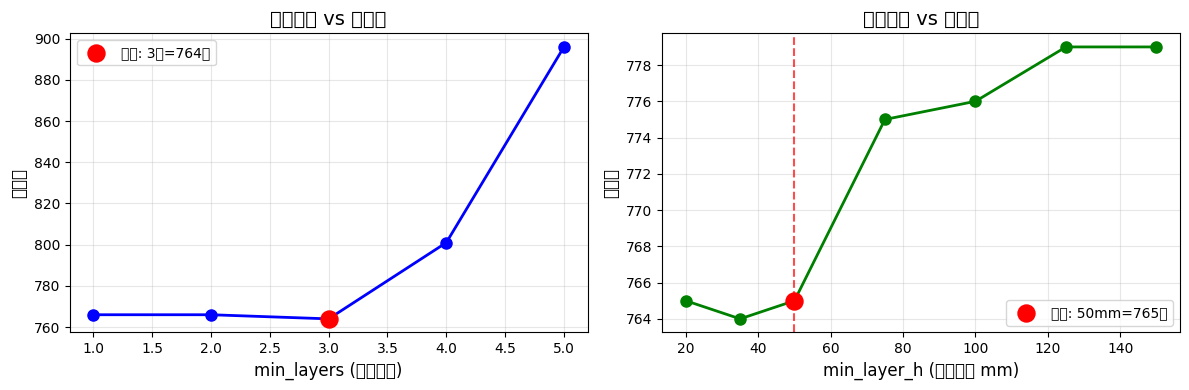


图表已保存: elbow_plot.png


{'min_layers': ([1, 2, 3, 4, 5], [766, 766, 764, 801, 896]),
 'min_layer_h': ([20, 35, 50, 75, 100, 125, 150],
  [765, 764, 765, 775, 776, 779, 779])}

In [15]:
analyze_hyperparams(df)

In [16]:
packer = train(df, min_layer_h=50)
export(packer, "装箱方案.xlsx")


玻璃种类: 701 | 总箱数: 12117
约束: 最少3层, 每层最低50mm
阶段1: 排序策略...
  area_desc: 765
  h_group_wc: 769
  width_desc: 769
  volume_desc: 770
  h_w_desc: 772
  height_desc: 774
  height_asc: 812
最佳: area_desc = 765 | 耗时: 215.0s

阶段2: 局部搜索...
  area_desc: 765 -> 765
  h_group_wc: 769 -> 769
  width_desc: 769 -> 769

货架统计
总货架数: 765
总箱数: 12117
平均利用率: 77.6%
总层数: 2580 | 空层: 2

按层数分类:
------------------------------
  3层货架:  533 个 ( 69.7%)
  4层货架:  194 个 ( 25.4%)
  5层货架:   26 个 (  3.4%)
  6层货架:   10 个 (  1.3%)
  7层货架:    1 个 (  0.1%)
  8层货架:    1 个 (  0.1%)
------------------------------

vs VBA(799): -34
总耗时: 434.3s

已导出: 装箱方案.xlsx (5827 条记录)


,货架号,货架层数,货架总高mm,货架利用率%,货架箱数,层号,层高mm,层已用宽mm,层箱数,位置号,玻璃ID,玻璃宽mm,玻璃高mm,叠放数
0,1,3,788.0,72.4,11,1,644.0,331.0,7,1,85,161.0,161.0,3
1,1,3,788.0,72.4,11,1,644.0,331.0,7,2,79,161.0,161.0,4
2,1,3,788.0,72.4,11,2,45.0,309.6,2,1,342,150.3,45.0,1
3,1,3,788.0,72.4,11,2,45.0,309.6,2,2,342,150.3,45.0,1
4,1,3,788.0,72.4,11,3,45.0,309.6,2,1,342,150.3,45.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5822,765,3,301.0,7.5,6,1,147.0,244.0,6,1,385,76.0,49.0,3
5823,765,3,301.0,7.5,6,1,147.0,244.0,6,2,370,75.0,46.0,1
5824,765,3,301.0,7.5,6,1,147.0,244.0,6,3,371,75.0,46.0,2
5825,765,3,301.0,7.5,6,2,50.0,0.0,0,-,(空),-,-,0


In [17]:
result = pd.read_excel("装箱方案.xlsx")
result.head(20)

,货架号,货架层数,货架总高mm,货架利用率%,货架箱数,层号,层高mm,层已用宽mm,层箱数,位置号,玻璃ID,玻璃宽mm,玻璃高mm,叠放数
0,1,3,788.0,72.4,11,1,644.0,331.0,7,1,85,161,161,3
1,1,3,788.0,72.4,11,1,644.0,331.0,7,2,79,161,161,4
2,1,3,788.0,72.4,11,2,45.0,309.6,2,1,342,150.3,45,1
3,1,3,788.0,72.4,11,2,45.0,309.6,2,2,342,150.3,45,1
4,1,3,788.0,72.4,11,3,45.0,309.6,2,1,342,150.3,45,1
5,1,3,788.0,72.4,11,3,45.0,309.6,2,2,342,150.3,45,1
6,2,4,799.0,70.3,11,1,280.0,348.0,3,1,79,161,161,1
7,2,4,799.0,70.3,11,1,280.0,348.0,3,2,7,178,140,2
8,2,4,799.0,70.3,11,2,264.0,351.2,3,1,8,177.2,132,2
9,2,4,799.0,70.3,11,2,264.0,351.2,3,2,46,165,130,1
